In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


from kneed import KneeLocator


In [14]:
file_path = 'src\\Dataset\\Liver Patient Dataset (LPD)_train.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

In [31]:
data.columns = data.columns.str.strip()

In [15]:
# data.fillna(data.mean(), inplace=True)

numeric_cols = data.select_dtypes(include=[np.number]).columns
non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns

data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

data[non_numeric_cols] = data[non_numeric_cols].fillna(data[non_numeric_cols].mode().iloc[0])



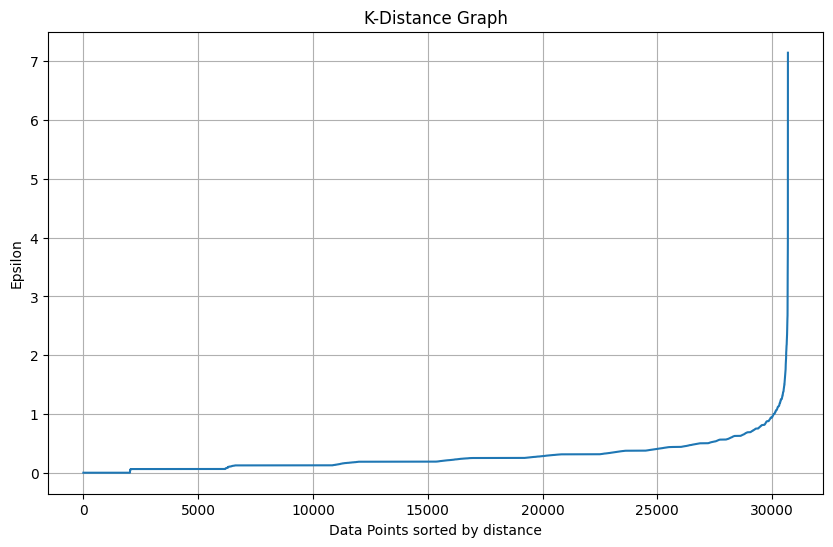

In [16]:
label_encoder = LabelEncoder()
data['Gender of the patient'] = label_encoder.fit_transform(data['Gender of the patient'].astype(str))

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop('Result', axis=1))

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.title('K-Distance Graph')
plt.grid(True)
plt.show()


In [17]:
optimal_eps = 1.5 

dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan.fit(scaled_data)

data['Cluster'] = dbscan.labels_

data_with_clusters = data[['Age of the patient', 'Gender of the patient', 'Total Bilirubin', 'Cluster']]
print(data_with_clusters.head())
print(data['Cluster'].value_counts())


   Age of the patient  Gender of the patient  Total Bilirubin  Cluster
0                65.0                      0              0.7        0
1                62.0                      1             10.9        1
2                62.0                      1              7.3        1
3                58.0                      1              1.0        1
4                72.0                      1              3.9        1
Cluster
 1     21039
 0      7134
 7       217
-1       112
 2        85
       ...  
 67        8
 76        7
 72        7
 50        7
 81        5
Name: count, Length: 83, dtype: int64


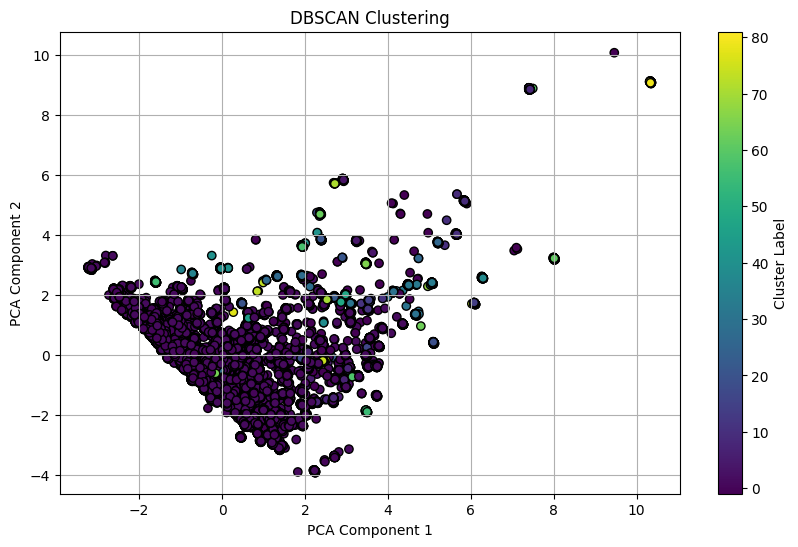

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=data['Cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering')
plt.grid(True)
plt.colorbar(label='Cluster Label')
plt.show()


In [19]:
nafld_columns = ['Age of the patient', 'Total Bilirubin', 'ALB Albumin', 'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase']
lft_columns = ['Total Bilirubin', 'Direct Bilirubin', 'Alkphos Alkaline Phosphotase', 'Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase', 'Total Protiens', 'ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio']
albi_columns = ['Total Bilirubin', 'ALB Albumin']

In [20]:
target = data['Result']

In [26]:
def determine_optimal_eps(scaled_data):
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(scaled_data)
    distances, indices = neighbors_fit.kneighbors(scaled_data)

    distances = np.sort(distances[:, 4], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel('Epsilon')
    plt.title('K-Distance Graph')
    plt.grid(True)
    plt.show()
    
    kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    optimal_eps = distances[kneedle.elbow]
    return optimal_eps

In [40]:

def apply_dbscan(data, columns, cluster_name):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[columns])

    optimal_eps = determine_optimal_eps(scaled_data)
    print(f"Optimal Epsilon for {cluster_name}: {optimal_eps}")

    dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
    dbscan.fit(scaled_data)

    data[cluster_name] = dbscan.labels_

    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=data[cluster_name], cmap='viridis', marker='o', edgecolor='k')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'DBSCAN Clustering for {cluster_name}')
    plt.grid(True)
    plt.colorbar(label='Cluster Label')
    plt.show()

    return data

In [23]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': LinearSVC(random_state=42, max_iter=10000),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Neural Network': MLPClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

In [28]:
def evaluate_models(X_train, X_test, y_train, y_test, method_name):
    accuracy_scores = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores[model_name] = accuracy
        print(f'{model_name} Accuracy for {method_name}: {accuracy}')
        print(classification_report(y_test, y_pred))
    return accuracy_scores

NAFLD Columns Clustering


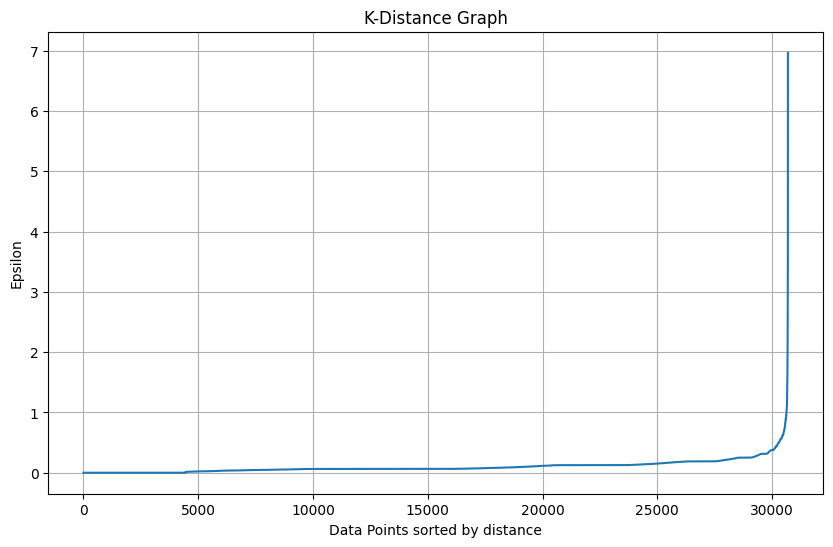

Optimal Epsilon for NAFLD_dbscan_Cluster: 1.1263895231223089


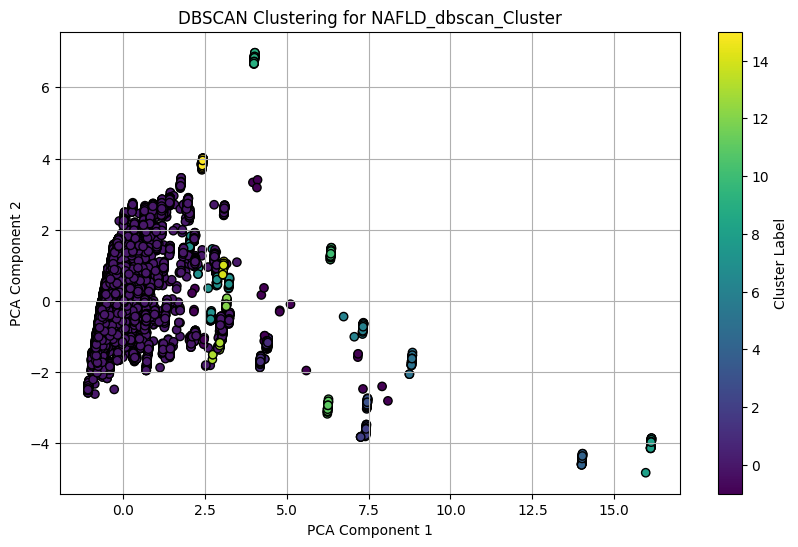

LFT Columns Clustering


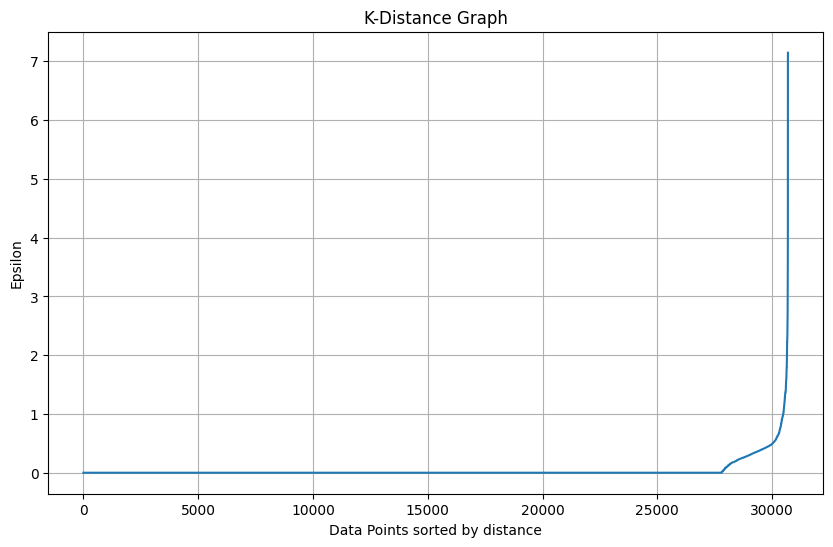

Optimal Epsilon for LFT_dbscan_Cluster: 2.6227035268191363


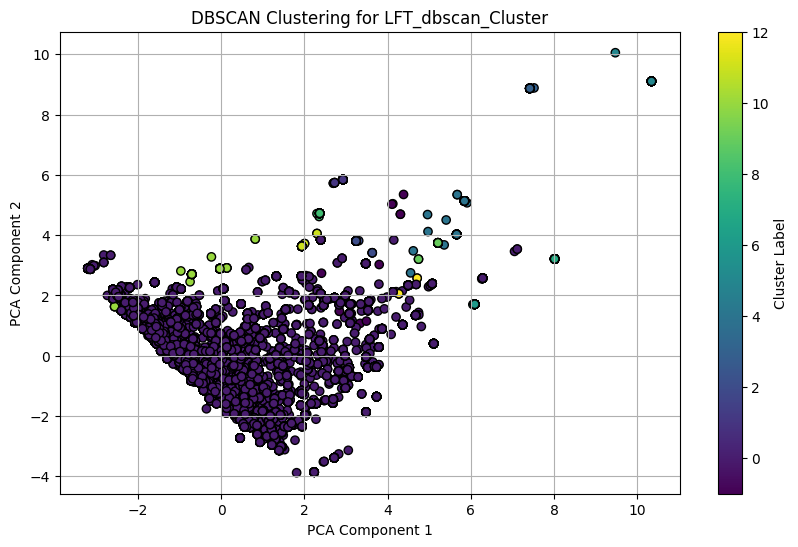

ALBI Columns Clustering


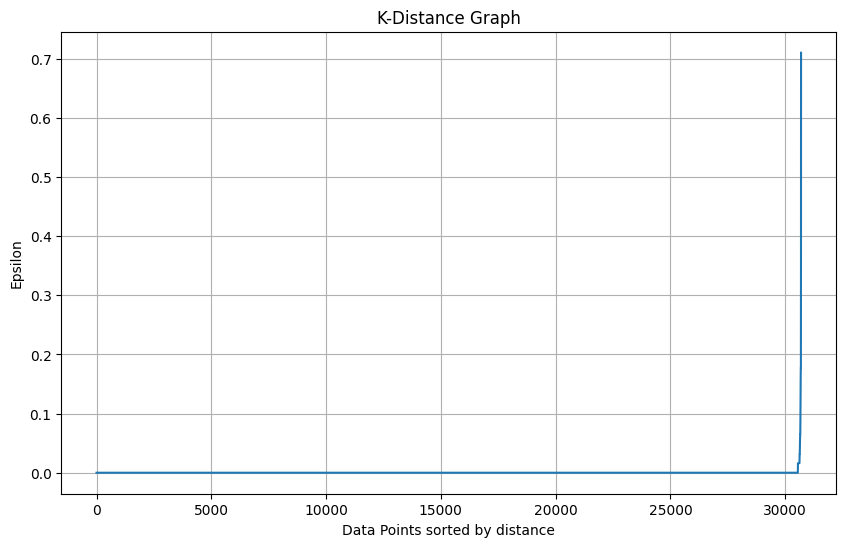

Optimal Epsilon for ALBI_dbscan_Cluster: 0.20525340770075207


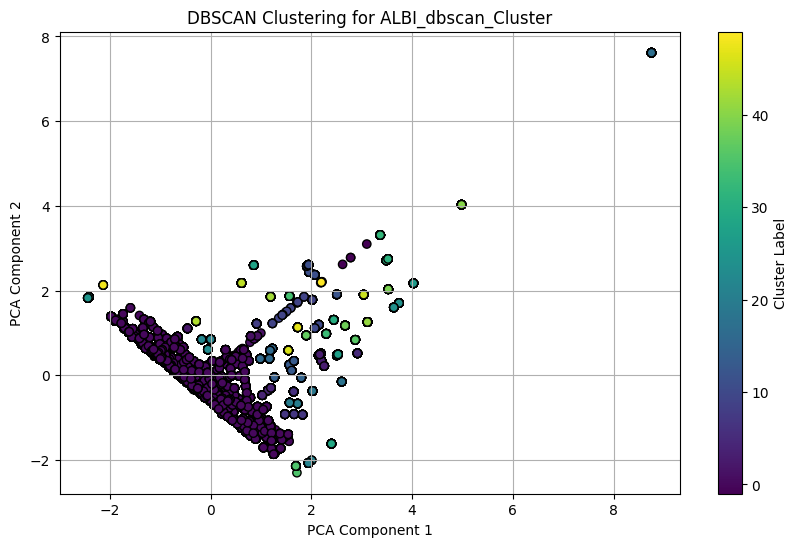

In [41]:
print("NAFLD Columns Clustering")
data = apply_dbscan(data, nafld_columns, 'NAFLD_dbscan_Cluster')

print("LFT Columns Clustering")
data = apply_dbscan(data, lft_columns, 'LFT_dbscan_Cluster')

print("ALBI Columns Clustering")
data = apply_dbscan(data, albi_columns, 'ALBI_dbscan_Cluster')

In [42]:
X_nafld = data[nafld_columns + ['NAFLD_dbscan_Cluster']]
X_lft = data[lft_columns + ['LFT_dbscan_Cluster']]
X_albi = data[albi_columns + ['ALBI_dbscan_Cluster']]
y = data['Result']

In [43]:
X_train_nafld, X_test_nafld, y_train, y_test = train_test_split(X_nafld, y, test_size=0.2, random_state=42)
X_train_lft, X_test_lft, y_train, y_test = train_test_split(X_lft, y, test_size=0.2, random_state=42)
X_train_albi, X_test_albi, y_train, y_test = train_test_split(X_albi, y, test_size=0.2, random_state=42)

In [ ]:

# # Train and evaluate the model on NAFLD features
# print("Training and evaluating on NAFLD features")
# ensemble_model.fit(X_train_nafld, y_train)
# y_pred_nafld = ensemble_model.predict(X_test_nafld)
# print("Accuracy:", accuracy_score(y_test, y_pred_nafld))
# print(classification_report(y_test, y_pred_nafld))

# # Train and evaluate the model on LFT features
# print("Training and evaluating on LFT features")
# ensemble_model.fit(X_train_lft, y_train)
# y_pred_lft = ensemble_model.predict(X_test_lft)
# print("Accuracy:", accuracy_score(y_test, y_pred_lft))
# print(classification_report(y_test, y_pred_lft))

# # Train and evaluate the model on ALBI features
# print("Training and evaluating on ALBI features")
# ensemble_model.fit(X_train_albi, y_train)
# y_pred_albi = ensemble_model.predict(X_test_albi)
# print("Accuracy:", accuracy_score(y_test, y_pred_albi))
# print(classification_report(y_test, y_pred_albi))

In [44]:
print("NAFLD Method")
nafld_accuracy = evaluate_models(X_train_nafld, X_test_nafld, y_train, y_test, 'NAFLD')

print("\nLFT Method")
lft_accuracy = evaluate_models(X_train_lft, X_test_lft, y_train, y_test, 'LFT')

print("\nALBI Method")
albi_accuracy = evaluate_models(X_train_albi, X_test_albi, y_train, y_test, 'ALBI')

NAFLD Method
Logistic Regression Accuracy for NAFLD: 0.7234077211272194
              precision    recall  f1-score   support

           1       0.73      0.97      0.84      4429
           2       0.52      0.08      0.14      1710

    accuracy                           0.72      6139
   macro avg       0.63      0.53      0.49      6139
weighted avg       0.67      0.72      0.64      6139

Random Forest Accuracy for NAFLD: 0.9944616387033719
              precision    recall  f1-score   support

           1       0.99      1.00      1.00      4429
           2       1.00      0.98      0.99      1710

    accuracy                           0.99      6139
   macro avg       1.00      0.99      0.99      6139
weighted avg       0.99      0.99      0.99      6139



C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

SVC Accuracy for NAFLD: 0.7214530053754683
              precision    recall  f1-score   support

           1       0.72      1.00      0.84      4429
           2       0.00      0.00      0.00      1710

    accuracy                           0.72      6139
   macro avg       0.36      0.50      0.42      6139
weighted avg       0.52      0.72      0.60      6139

Naive Bayes Accuracy for NAFLD: 0.48770158006189934
              precision    recall  f1-score   support

           1       0.96      0.30      0.46      4429
           2       0.35      0.97      0.51      1710

    accuracy                           0.49      6139
   macro avg       0.66      0.64      0.49      6139
weighted avg       0.79      0.49      0.47      6139

K-Nearest Neighbors Accuracy for NAFLD: 0.9037302492262583
              precision    recall  f1-score   support

           1       0.94      0.93      0.93      4429
           2       0.82      0.83      0.83      1710

    accuracy                

C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy for LFT: 0.7175435738719661
              precision    recall  f1-score   support

           1       0.74      0.93      0.83      4429
           2       0.48      0.17      0.25      1710

    accuracy                           0.72      6139
   macro avg       0.61      0.55      0.54      6139
weighted avg       0.67      0.72      0.67      6139

Random Forest Accuracy for LFT: 0.9975566053103111
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4429
           2       1.00      0.99      1.00      1710

    accuracy                           1.00      6139
   macro avg       1.00      1.00      1.00      6139
weighted avg       1.00      1.00      1.00      6139



C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVC Accuracy for LFT: 0.7100504968235869
              precision    recall  f1-score   support

           1       0.72      0.98      0.83      4429
           2       0.00      0.00      0.00      1710

    accuracy                           0.71      6139
   macro avg       0.36      0.49      0.42      6139
weighted avg       0.52      0.71      0.60      6139

Naive Bayes Accuracy for LFT: 0.5132757778139763
              precision    recall  f1-score   support

           1       0.97      0.34      0.50      4429
           2       0.36      0.97      0.53      1710

    accuracy                           0.51      6139
   macro avg       0.66      0.65      0.51      6139
weighted avg       0.80      0.51      0.51      6139

K-Nearest Neighbors Accuracy for LFT: 0.9907151001791823
              precision    recall  f1-score   support

           1       0.99      1.00      0.99      4429
           2       0.99      0.98      0.98      1710

    accuracy                       

C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

Random Forest Accuracy for ALBI: 0.8678937937774882
              precision    recall  f1-score   support

           1       0.91      0.91      0.91      4429
           2       0.76      0.76      0.76      1710

    accuracy                           0.87      6139
   macro avg       0.84      0.83      0.84      6139
weighted avg       0.87      0.87      0.87      6139



C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVC Accuracy for ALBI: 0.7214530053754683
              precision    recall  f1-score   support

           1       0.72      1.00      0.84      4429
           2       0.00      0.00      0.00      1710

    accuracy                           0.72      6139
   macro avg       0.36      0.50      0.42      6139
weighted avg       0.52      0.72      0.60      6139

Naive Bayes Accuracy for ALBI: 0.44029972308193516
              precision    recall  f1-score   support

           1       0.96      0.23      0.38      4429
           2       0.33      0.98      0.49      1710

    accuracy                           0.44      6139
   macro avg       0.65      0.61      0.43      6139
weighted avg       0.79      0.44      0.41      6139



C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ssudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

K-Nearest Neighbors Accuracy for ALBI: 0.8493239941358528
              precision    recall  f1-score   support

           1       0.90      0.88      0.89      4429
           2       0.72      0.76      0.74      1710

    accuracy                           0.85      6139
   macro avg       0.81      0.82      0.82      6139
weighted avg       0.85      0.85      0.85      6139

Neural Network Accuracy for ALBI: 0.7258511158169083
              precision    recall  f1-score   support

           1       0.73      0.98      0.84      4429
           2       0.58      0.06      0.10      1710

    accuracy                           0.73      6139
   macro avg       0.66      0.52      0.47      6139
weighted avg       0.69      0.73      0.63      6139

Decision Tree Accuracy for ALBI: 0.8687082586740511
              precision    recall  f1-score   support

           1       0.91      0.91      0.91      4429
           2       0.77      0.75      0.76      1710

    accuracy       

In [45]:
def compare_accuracies(nafld_accuracy, lft_accuracy, albi_accuracy):
    print("\nOverall Accuracy Comparison:")
    for model_name in models.keys():
        print(f"{model_name}:")
        print(f"  NAFLD Accuracy: {nafld_accuracy[model_name]}")
        print(f"  LFT Accuracy: {lft_accuracy[model_name]}")
        print(f"  ALBI Accuracy: {albi_accuracy[model_name]}")
        print()


In [46]:
compare_accuracies(nafld_accuracy, lft_accuracy, albi_accuracy)


Overall Accuracy Comparison:
Logistic Regression:
  NAFLD Accuracy: 0.7234077211272194
  LFT Accuracy: 0.7175435738719661
  ALBI Accuracy: 0.7214530053754683

Random Forest:
  NAFLD Accuracy: 0.9944616387033719
  LFT Accuracy: 0.9975566053103111
  ALBI Accuracy: 0.8678937937774882

SVC:
  NAFLD Accuracy: 0.7214530053754683
  LFT Accuracy: 0.7100504968235869
  ALBI Accuracy: 0.7214530053754683

Naive Bayes:
  NAFLD Accuracy: 0.48770158006189934
  LFT Accuracy: 0.5132757778139763
  ALBI Accuracy: 0.44029972308193516

K-Nearest Neighbors:
  NAFLD Accuracy: 0.9037302492262583
  LFT Accuracy: 0.9907151001791823
  ALBI Accuracy: 0.8493239941358528

Neural Network:
  NAFLD Accuracy: 0.7724385079003095
  LFT Accuracy: 0.7512624205896726
  ALBI Accuracy: 0.7258511158169083

Decision Tree:
  NAFLD Accuracy: 0.9918553510343704
  LFT Accuracy: 0.9915295650757452
  ALBI Accuracy: 0.8687082586740511

